<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/nebula_NGC_3372.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nebula NGC 3372 (Carina Nebula)**

https://en.m.wikipedia.org/wiki/Carina_Nebula

![sciences](https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Carina_Nebula_by_Harel_Boren_%28151851961%2C_modified%29.jpg/985px-Carina_Nebula_by_Harel_Boren_%28151851961%2C_modified%29.jpg)

In [ ]:
!pip install astropy astroquery -q
from astroquery.ipac.irsa import Irsa
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astropy import coordinates
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Define object
object_name = 'NGC 3372'

In [ ]:
# Get and set skycoordinates of object
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord

skyobject = Simbad.query_object(object_name)
ra_hms = skyobject['RA'][0]
dec_dms = skyobject['DEC'][0]
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
print(skyobject)
print("\nCoordinates:")
print("RA (h:m:s):", ra_hms)
print("DEC (d:m:s):", dec_dms)

 MAIN_ID       RA         DEC     RA_PREC ... COO_WAVELENGTH     COO_BIBCODE     SCRIPT_NUMBER_ID
            "h:m:s"     "d:m:s"           ...                                                    
--------- ----------- ----------- ------- ... -------------- ------------------- ----------------
NGC  3372 10 45 02.23 -59 41 59.8       6 ...              O 2019ApJ...870...32K                1

Coordinates:
RA (h:m:s): 10 45 02.23
DEC (d:m:s): -59 41 59.8


In [ ]:
# Convert from Right Ascension (RA) and Declination (DEC) to decimal degree
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
ra_deg = coord.ra.deg # round(coord.ra.deg, 2)
dec_deg = coord.dec.deg # round(coord.dec.deg, 2)

print("RA in degrees:", ra_deg)
print("DEC in degrees:", dec_deg)

RA in degrees: 161.25929166666666
DEC in degrees: -59.69994444444444


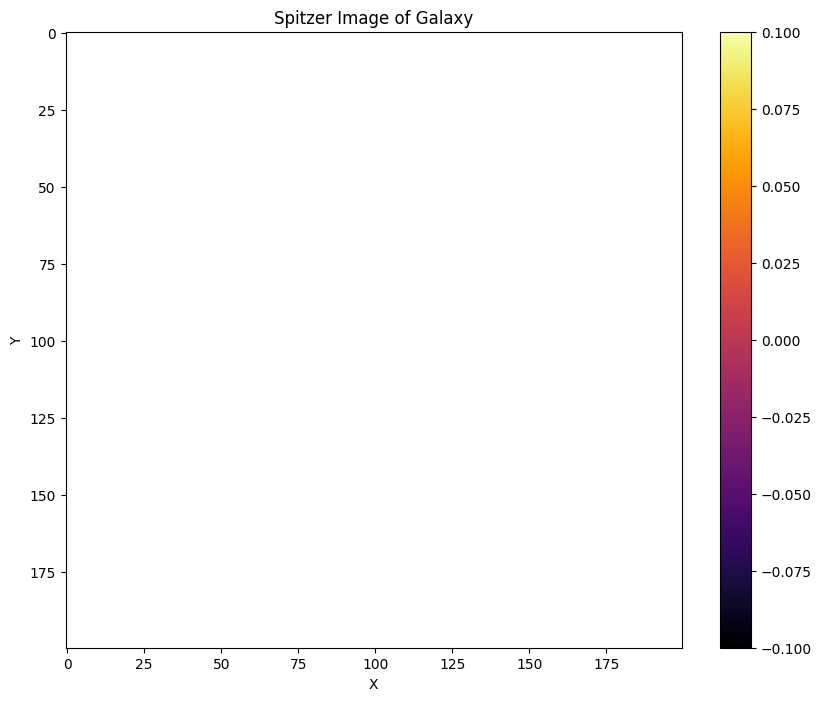

In [ ]:
# Simple image access queries from IRSA images from Spitzer telescope
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection='spitzer_seip').to_table()

# Open a cutout image for one of the science images
science_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][0]
with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].section, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8))
plt.imshow(cutout.data, cmap='inferno')
plt.colorbar()
plt.title('Spitzer Image of Galaxy')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# How many science picture are therein spitzer_images?
science_images_count = len(spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'])
print("Number of science images:", science_images_count)

Number of science images: 30


In [ ]:
# Multi-wavelength image with MAST
# Check available records for a given object and propose ideal RGB filters to visualize

from astroquery.mast import Observations
import astropy.units as u
from astropy.coordinates import SkyCoord
from collections import defaultdict

def check_hst_data_availability(coord, radius=0.2*u.deg):
    """
    Check available HST data for given coordinates.

    Parameters:
    coords: SkyCoord object with the target coordinates
    radius: search radius (default 0.2 degrees)
    """
    print(f"Querying MAST for coordinates: {coord.to_string('hmsdms')}")
    print(f"Search radius: {radius}")
    print("\n" + "="*50)

    # Query observations
    obs_table = Observations.query_region(coord, radius=radius)

    # Filter for HST observations
    hst_obs = obs_table[obs_table['obs_collection'] == 'HST']

    # Organize by instrument
    instruments = defaultdict(lambda: defaultdict(list))

    for obs in hst_obs:
        instrument = obs['instrument_name']
        filt = obs['filters']
        if filt:  # Some observations might not have filter info
            # Get product list for this observation
            products = Observations.get_product_list(obs['obsid'])
            drz_products = products[products['productSubGroupDescription'] == 'DRZ']

            instruments[instrument][filt].append({
                'obsid': obs['obsid'],
                'drz_count': len(drz_products),
                'proposal_id': obs['proposal_id'],
                'obs_date': obs['t_min']
            })

    # Print detailed report
    for instrument in sorted(instruments.keys()):
        print(f"\nInstrument: {instrument}")
        print("-" * 30)

        for filt in sorted(instruments[instrument].keys()):
            obs_list = instruments[instrument][filt]
            drz_count = sum(1 for obs in obs_list if obs['drz_count'] > 0)

            print(f"\nFilter: {filt}")
            print(f"Total observations: {len(obs_list)}")
            print(f"Observations with DRZ products: {drz_count}")

            if drz_count > 0:
                print("\nDetails of observations with DRZ products:")
                for obs in obs_list:
                    if obs['drz_count'] > 0:
                        print(f"  - ObsID: {obs['obsid']}")
                        print(f"    Proposal ID: {obs['proposal_id']}")
                        print(f"    Date: {obs['obs_date']}")
                        print(f"    DRZ files: {obs['drz_count']}")

    return instruments

# Let's try it with M104 (Sombrero Galaxy)
coord_m104 = SkyCoord('12h39m59.4s -11d37m23s', unit=(u.hourangle, u.deg))
instruments_m104 = check_hst_data_availability(coord_m104)

print("\n\nSuggested Filter Combinations:")
print("="*50)

# Look for potential filter combinations for RGB images
for instrument in instruments_m104.keys():
    filters_with_drz = []
    for filt, obs_list in instruments_m104[instrument].items():
        if any(obs['drz_count'] > 0 for obs in obs_list):
            filters_with_drz.append(filt)

    if len(filters_with_drz) >= 3:
        print(f"\n{instrument} possible combinations:")
        # Group filters by wavelength range (UV, optical, IR)
        uv_filters = [f for f in filters_with_drz if 'F' in f and int(f[1:4]) < 400]
        optical_filters = [f for f in filters_with_drz if 'F' in f and 400 <= int(f[1:4]) <= 700]
        ir_filters = [f for f in filters_with_drz if 'F' in f and int(f[1:4]) > 700]

        print("  Suggested RGB combinations:")
        if len(optical_filters) >= 3:
            print(f"  - Natural colors: {sorted(optical_filters[:3])}")
        if uv_filters and optical_filters and ir_filters:
            print(f"  - Extended range: {sorted([uv_filters[0], optical_filters[0], ir_filters[0]])}")

Querying MAST for coordinates: 12h39m59.4s -11d37m23s
Search radius: 0.2 deg


Instrument: ACS/HRC
------------------------------

Filter: F220W
Total observations: 12
Observations with DRZ products: 12

Details of observations with DRZ products:
  - ObsID: 24818980
    Proposal ID: 9714
    Date: 52804.439263078704
    DRZ files: 7
  - ObsID: 26336162
    Proposal ID: 9714
    Date: 52804.43926308
    DRZ files: 6
  - ObsID: 24818976
    Proposal ID: 9714
    Date: 52804.218105671294
    DRZ files: 7
  - ObsID: 26336151
    Proposal ID: 9714
    Date: 52804.21810567
    DRZ files: 6
  - ObsID: 24818972
    Proposal ID: 9714
    Date: 52799.29667048611
    DRZ files: 7
  - ObsID: 26336144
    Proposal ID: 9714
    Date: 52799.29667049
    DRZ files: 6
  - ObsID: 24818968
    Proposal ID: 9714
    Date: 52798.421959756946
    DRZ files: 7
  - ObsID: 26336154
    Proposal ID: 9714
    Date: 52798.42195975
    DRZ files: 6
  - ObsID: 24818964
    Proposal ID: 9714
    Date: 52795.48123047

In [ ]:
!pip install reproject -q
from astroquery.mast import Observations
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from reproject import reproject_interp

def process_hst_images(coords, filters_dict, radius=0.2*u.deg):
    print("Querying MAST...")
    obs_table = Observations.query_region(coords, radius=radius)

    # Filter for HST observations with specific filters
    hst_obs = obs_table[obs_table['instrument_name'] == instrument]

    # Create dictionary to store filter observations
    filter_obs = {}
    for color, filter_name in filters_dict.items():
        filter_obs[color] = hst_obs[hst_obs['filters'] == filter_name]
        print(f"{filter_name} ({color}): {len(filter_obs[color])} observations")

    # Check if we have all needed filters
    missing_filters = [color for color, obs in filter_obs.items() if len(obs) == 0]

    if missing_filters:
        print("\nMissing filters for colors:", missing_filters)
        print("Available filters:", sorted(set(hst_obs['filters'])))
        return

    print("\nDownloading data products...")

    # Get products for each filter
    products = {}
    drz_products = {}

    for color, obs in filter_obs.items():
        products[color] = Observations.get_product_list(obs[0]['obsid'])
        drz_products[color] = products[color][products[color]['productSubGroupDescription'] == 'DRZ']

        if len(drz_products[color]) == 0:
            print(f"Missing DRZ products for {filters_dict[color]} ({color})")
            return

    # Download files
    files = {}
    for color in filters_dict.keys():
        files[color] = Observations.download_products(drz_products[color])
        if files[color] is None:
            print(f"Download failed for {filters_dict[color]}")
            return

    print("\nProcessing images...")

    try:
        # Open all files
        hdus = {}
        for color in filters_dict.keys():
            hdus[color] = fits.open(files[color]['Local Path'][0])[1]

        print("Aligning images...")
        # Reproject blue and green to red's frame
        data = {}
        data['red'] = hdus['red'].data
        data['blue'], _ = reproject_interp(hdus['blue'], hdus['red'].header)
        data['green'], _ = reproject_interp(hdus['green'], hdus['red'].header)

        print("Normalizing data...")
        def normalize(arr):
            arr = np.nan_to_num(arr, 0)
            return arr / np.percentile(arr[arr > 0], 99)

        norm_data = {color: normalize(data[color]) for color in filters_dict.keys()}

        print("Creating color composite...")
        rgb = make_lupton_rgb(norm_data['red'],
                            norm_data['green'],
                            norm_data['blue'],
                            Q=10, stretch=0.5)

        plt.figure(figsize=(10, 10))
        plt.imshow(rgb, origin='lower')
        plt.title(f'HST ACS/WFC Composite\nR: {filters_dict["red"]}, G: {filters_dict["green"]}, B: {filters_dict["blue"]}')
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing images: {str(e)}")
        print("Try using different observations or filters.")

In [ ]:
# Example usage for M104
if __name__ == "__main__":
    # Set your filters once here

    instrument = 'WFC3/UVIS'

    FILTERS = {
        'blue': 'F275W',
        'green': 'F606W',
        'red': 'F814W'
    }

    # Define coordinates
    coords = coord #SkyCoord('12h39m59.4s -11d37m23s', unit=(u.hourangle, u.deg))

    # Process the images
    process_hst_images(coords, FILTERS)

Querying MAST...
F275W (blue): 3 observations
F606W (green): 2 observations
F814W (red): 15 observations

Missing DRZ products for F275W (blue)
